# Bajaj Finance

In [26]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import gensim
import pandas as pd
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/nbfc/bajaj_finance/bajaj_finance.csv')

In [3]:
# Company username
company_username = 'Bajaj_Finance'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [6]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [7]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [9]:
qdf.shape

(22528, 28)

In [10]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 17499


In [11]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [12]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [14]:
for index, conversation_id in tqdm(enumerate(conversation_ids)):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

0it [00:00, ?it/s]

In [15]:
result.head()

,conversation_id,response_time
0,1344317386132844545,0.000000
1,1343935142734123013,0.278611
2,1344311687264944128,0.000000
3,1344314012373188616,0.000000
4,1344286581432016896,1.002500


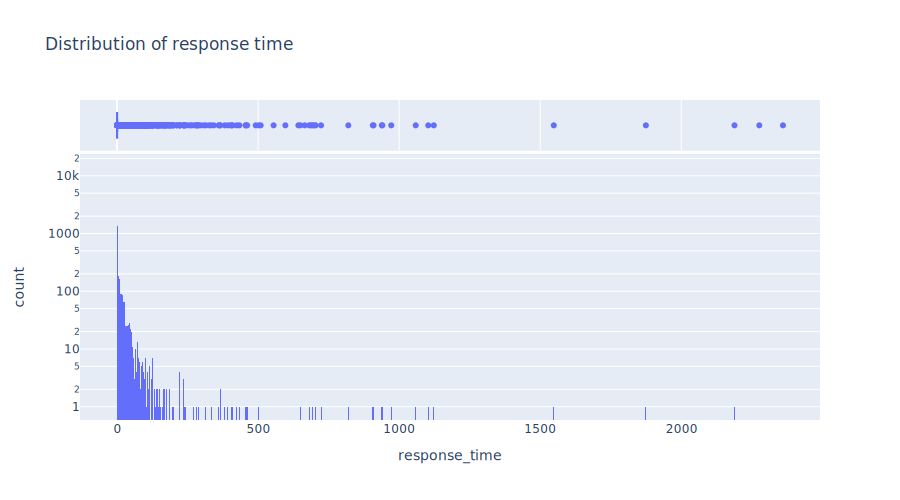

In [17]:
fig = px.histogram(result, x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [ ]:
result['resolution_time'] = 0

In [18]:
for index, conversation_id in tqdm(enumerate(conversation_ids)):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

0it [00:00, ?it/s]

In [19]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 12404
Number of queries unresolved: 5095


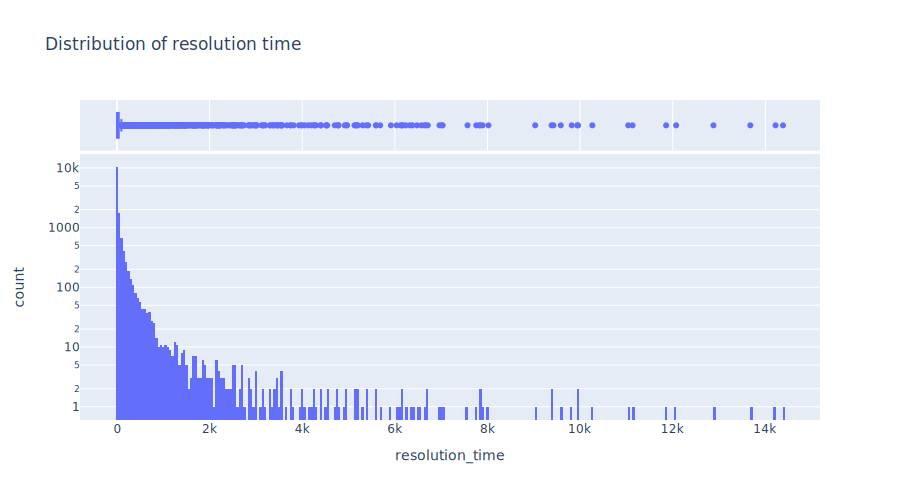

In [20]:
fig = px.histogram(result, x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

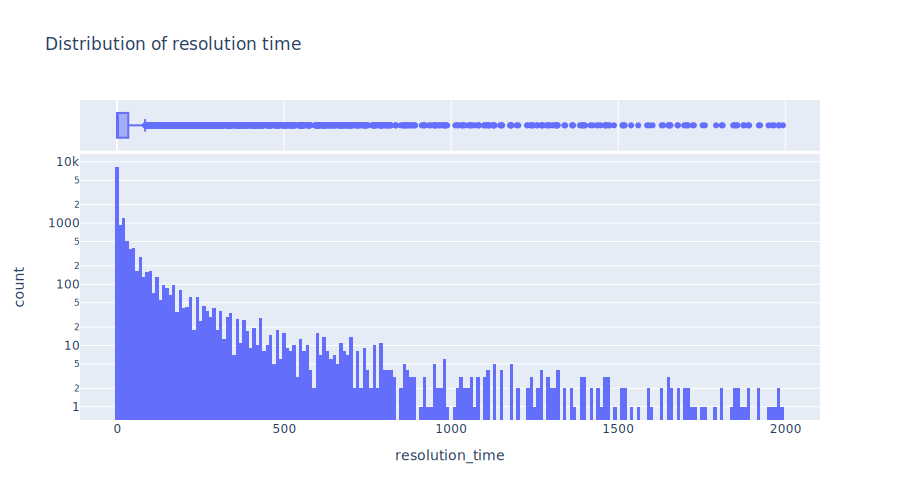

In [22]:
fig = px.histogram(result[result['resolution_time']<2000], x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [21]:
result.describe()

,response_time,resolution_time
count,17499.000000,14530.000000
mean,5.613538,107.529518
std,49.460617,570.374006
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.817778
75%,0.536944,37.756319
max,2360.426389,14380.907222


## Query Tweets Topics

In [23]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[queries['inReplyToTweetId'] == 'nan']
queries.shape

(7782, 28)

In [27]:
processor = Processor('./../../data/config.json')
queries = processor.preprocess_individual(queries)
id2word = gensim.corpora.Dictionary(queries['bigram'].values.tolist())
corpus = [id2word.doc2bow(text) for text in queries['bigram'].values.tolist()]

In [34]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.3,
                                        eta=0.3)
coherence_model = gensim.models.CoherenceModel(model=lda_model, 
                                                    texts=queries['bigram'].values.tolist(), 
                                                    dictionary=id2word, 
                                                    coherence='u_mass')
coherence_model_score = coherence_model.get_coherence()
print('Coherence Score: ', coherence_model_score)
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

Coherence Score:  -8.068067245141798


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.131423 -0.054081       1        1  43.794797
0     -0.152454  0.135076       2        1  23.254554
1      0.049154 -0.175121       3        1  17.650108
3      0.234722  0.094126       4        1  15.300540, topic_info=                  Term         Freq        Total Category  logprob  loglift
17                 emi  1065.000000  1065.000000  Default  30.0000  30.0000
30               calls   430.000000   430.000000  Default  29.0000  29.0000
387            calling   292.000000   292.000000  Default  28.0000  28.0000
92              number   635.000000   635.000000  Default  27.0000  27.0000
554        customer_id   190.000000   190.000000  Default  26.0000  26.0000
..                 ...          ...          ...      ...      ...      ...
152  registered_mobile    58.232603    86.668779   Topic4  -5.4387   1.4796
92              number    97.110568   635.042362   Topic4  -4.9273  -0.0006
142          sudhanshu    53.683677    72.008267   Topic4  -5.5201   1.5836
17                 emi    59.142368  1065.340789   Topic4  -5.4232  -1.0138
55                loan    58.264051  1107.652860   Topic4  -5.4382  -1.0677

[256 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
63        1  0.609276          account
63        2  0.006505          account
63        3  0.301386          account
63        4  0.080225          account
996       1  0.287108           action
...     ...       ...              ...
111       3  0.089506             want
111       4  0.004475             want
1445      4  0.976406     working_days
3381      4  0.981230  working_resolve
2308      3  0.964524    xxxxxx_shared

[422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

In [35]:
queries_topic_sents_keywords = processor.dominant_topics(ldamodel=lda_model, 
                                                         corpus=corpus, 
                                                         texts=queries['bigram'].values.tolist(),
                                                         tweets=queries['tweet'].values.tolist())
queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['emi, loan, contact_details, reference_post, customer_id, dm_registered, assist_thank, greetings_kindly, details, greetings',
       'calls, number, calling, loan, stop, guys, people, dnd, getting, day',
       'loan, emi, customer, card, help, service, team, account, emi_card, time',
       'like_address, greetings_reference, unfortunate_hear, hai, experience_wed, se, assist_thank, details_earliest, contact_details, resolve_query'],
      dtype=object)

In [36]:
select = queries_topic_sents_keywords['Topic_Keywords'].unique()[1]
queries_topic_sents_keywords[queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

array(['@Bajaj_Finance I have complained several times but still I get random calls from you fellows. Pls let other live , go and give card / loans to those who need and stop bothering with your shit calls #Spam https://t.co/9cstSXHm8O',
       '@Bajaj_Finance what do you want should i just stop using your services. When i called your customer service this fucking ivr would not let me connect to a live person and you deduct wrong amount from my account.\n\n#stopbajaj #Farudbajajfinserv',
       'If you ever wish to get a vehicle never ever get a loan from @Bajaj_Finance , you guys sucks',
       ...,
       'Respected @PMOIndia @HMOIndia @ConsumerReports @consumercourtin  sir requesting you pls check this matter @Bajaj_Finance is cheating with consumers Through Elite loan scheme . They are taking highinterest against loan.They are taking 7668 rs interest on 34000 loan in 22 mnth',
       '@Bajaj_Finserv @sanjivrbajaj @Bajaj_Finserv I have active home loan from Bajaj finance and I am fe

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



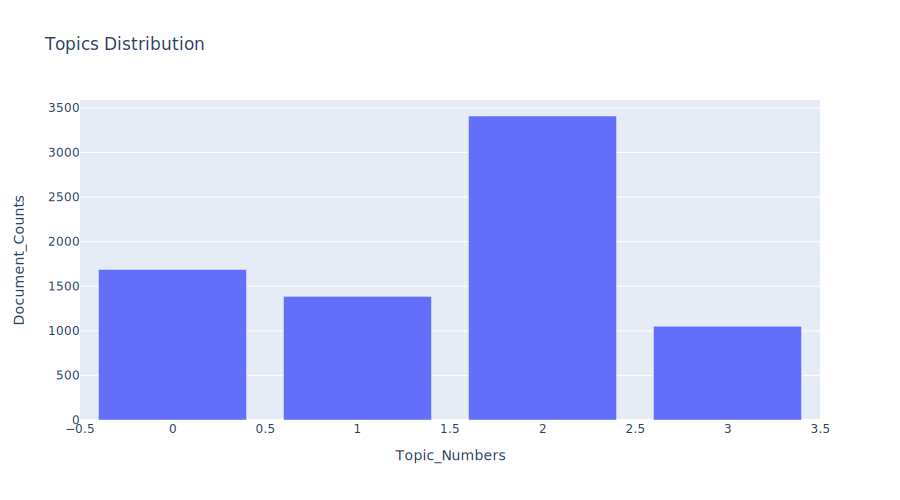

In [37]:
queries_dist, fig = processor.plot_topic_distribution(queries_topic_sents_keywords)
fig.show()